In [1]:
# default_exp pid

# pid

> API details.

In [1]:
#hide
from nbdev.showdoc import *

In [2]:
#export
from pidctl.imports import *
from pidctl.core import kwargs2str

In [22]:
#export
class Pid:
    def __init__(self, Kp=0, Ki=0, Kd=0, set_point=0, sample_time=0.01) -> None:
        self.Kp, self.Ki, self.Kd = Kp, Ki, Kd
        self.set_point = set_point
        self.sample_time = sample_time
        self._last_error, self._proportional, self._integral, self._derivative = 0, 0, 0, 0
        self._last_time, self._last_output, self._last_input = None, None, None
    
    def __call__(self, input):
        error = self.set_point - input
        current_time = time.time()
        dt = current_time - self._last_time if self._last_time is not None else 1e-16
        d_input = input - (self._last_input if (self._last_input is not None) else input)
        if self.sample_time is not None and dt < self.sample_time and self._last_output is not None: return self._last_output
        self._proportional = self.Kp * error
        self._integral += self.Ki * error * dt
        self._derivative = -self.Kd * d_input / dt
        output = self._proportional + self._integral + self._derivative
        self._last_output = output
        self._last_input = input
        self._last_time = current_time
        return output
    
    def __repr__(self):
        return f"Pid params:\n{kwargs2str(kp=self.Kp, ki=self.Ki, kd=self.Kd, set_point=self.set_point, sample_time=self.sample_time)}\n"

In [23]:
Pid()

Pid params:
kp: 0, ki: 0, kd: 0, set_point: 0, sample_time: 0.01

In [24]:
class ACSimulator:
    def __init__(self, room_temp) -> None:
        self.room_temp = room_temp
        self._initial_room_temp = room_temp
    
    def update(self, cool_power, dt):
        if cool_power > 0:
            self.room_temp -= 1 * cool_power * dt
        else:
            self.room_temp += 1 * cool_power * dt
        self.room_temp += (self._initial_room_temp - self.room_temp) * 0.02 * dt
        return self.room_temp

In [25]:
room_temp = 32
ac = ACSimulator(room_temp)
pid = Pid(5, 0.01, 0.1, set_point=room_temp)
start_time = time.time()
last_time = start_time
setpoint, y, x = [], [], []

In [26]:
pid

Pid params:
kp: 5, ki: 0.01, kd: 0.1, set_point: 32, sample_time: 0.01

In [27]:
while time.time() - start_time < 10:
    current_time = time.time()
    dt = current_time - last_time

    power = pid(room_temp)
    room_temp = ac.update(power, dt)

    x += [current_time - start_time]
    y += [room_temp]
    setpoint += [pid.set_point]

    if current_time - start_time > 1:
        pid.set_point = 23
    last_time = current_time

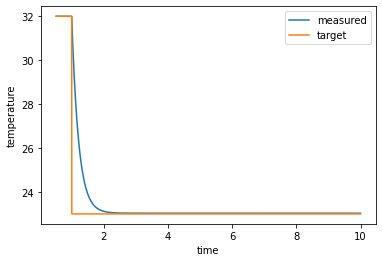

In [29]:
import matplotlib.pyplot as plt
plt.plot(x, y, label='measured')
plt.plot(x, setpoint, label='target')
plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()
plt.show()